In [200]:
import torch
import torchaudio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
from scipy.fft import dct
from nnAudio.features.gammatone import Gammatonegram

In [201]:
class GFCCExtractor:
    def __init__(self, sample_rate, n_gfcc, n_fft, hop_length, f_min, f_max, window, center, delta_win,device):
        """
        初始化GFCC提取器
        
        Args:
            sample_rate: 采样率
            n_gfcc: GFCC系数数量
            n_bins: Gammatone滤波器数量
            n_fft: FFT窗口大小
            hop_length: 跳跃长度
            f_min: 最低频率
            f_max: 最高频率 (None时使用sample_rate/2)
            window: 窗口函数类型
            center: 是否将STFT核心置于时间步中心
            device: 计算设备 ('cpu' 或 'cuda')
        """
        self.sample_rate = sample_rate
        self.n_gfcc = n_gfcc
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.f_min = f_min
        self.f_max = f_max if f_max is not None else sample_rate // 2
        self.window = window
        self.center = center
        self.delta_win = int(delta_win) if delta_win % 2 == 1 else int(delta_win + 1)
        self.device = device
        # 初始化Gammatonegram变换器
        self.gammatone_transform = Gammatonegram(
            sr=self.sample_rate,
            n_fft=self.n_fft,
            hop_length=self.hop_length,
            fmin=self.f_min,
            fmax=self.f_max,
            window=self.window,
            center=self.center,
        ).to(device)

    def extract_gfcc_features(self, waveform, do_cmvn, do_deltas) :
        """
        提取GFCC特征
        
        Args:
            waveform: 输入音频波形 [batch_size, channels, samples] 或 [samples]
            
        Returns:
            gfcc_features: GFCC特征 [batch_size, n_gfcc, time_frames]
        """
        waveform = waveform.to(self.device)
        gammatone_spec = self.gammatone_transform(waveform)
        power = gammatone_spec ** 2
        log_spec = torch.log10(power)

        log_spec_np = log_spec.detach().cpu().numpy()
        gfcc = dct(log_spec_np, type=2, axis=1, norm='ortho')[:, :self.n_gfcc, :]
        gfcc = torch.from_numpy(gfcc).to(self.device)

        if  do_cmvn:
            gfcc = (gfcc - gfcc.mean(dim=1, keepdim=True)) / gfcc.std(dim=1, keepdim=True)

        if do_deltas:
            delta_1 = torchaudio.functional.compute_deltas(gfcc, win_length=self.delta_win)
            delta_2 = torchaudio.functional.compute_deltas(delta_1, win_length=self.delta_win)
            gfcc = torch.cat([gfcc, delta_1, delta_2], dim=1)

        if waveform.shape[0] == 1:
            gfcc_features = gfcc.squeeze(0)
            
        return gfcc_features

In [202]:
def plot_gfcc_features(gfcc_features, sample_rate, hop_length, title):
        """
        可视化GFCC特征

        Args:
                gfcc_features: GFCC特征张量
                sample_rate: 采样率
                hop_length: 跳跃长度
                title: 图表标题
        """
        plt.figure(figsize=(12, 8))
        librosa.display.specshow(gfcc_features, sr=sample_rate, hop_length=hop_length, x_axis='time')
        plt.title(title)
        plt.xlabel('Time')
        plt.ylabel('GFCC Coefficient')
        plt.colorbar(format='%+2.0f')
        plt.tight_layout()
        plt.show()

STFT kernels created, time used = 0.0130 seconds
STFT filter created, time used = 0.0020 seconds
Gammatone filter created, time used = 0.0020 seconds


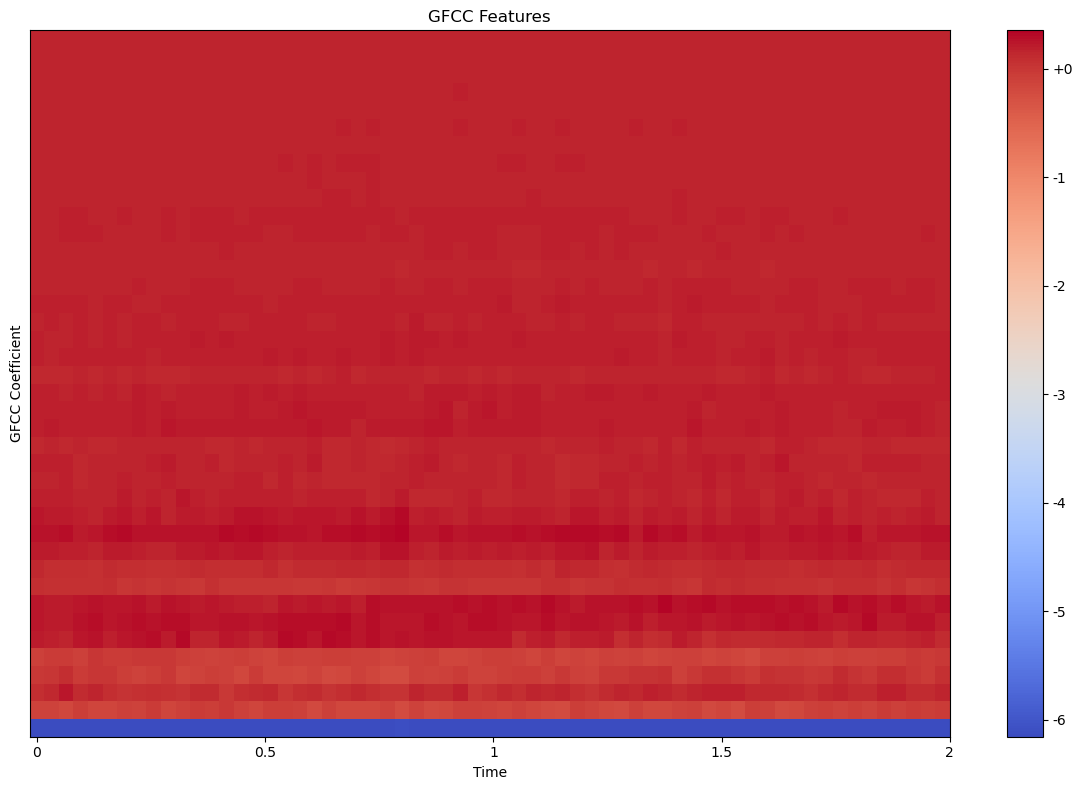

In [203]:
wav_file = r"E:\数据集\ShipEar\data_preprocessing\3_Frame_Windows_2s_50%\6__10_07_13_marDeCangas_Entra_18.wav"

waveform, original_sr = torchaudio.load(wav_file)

frame_length = 2048
hop_length = 512

target_sr = 16000
if original_sr != target_sr:
    resampler = torchaudio.transforms.Resample(original_sr, target_sr)
    waveform = resampler(waveform)

gfcc_extractor = GFCCExtractor(sample_rate=target_sr, n_gfcc=40, n_fft=1024, hop_length=512, f_min=20, f_max=8000, window='hann', center=True, delta_win=9, device='cuda:0')
gfcc_features = gfcc_extractor.extract_gfcc_features(waveform, do_cmvn=True, do_deltas=False)
gfcc_features = gfcc_features.cpu().numpy()
plot_gfcc_features(gfcc_features, target_sr, hop_length, 'GFCC Features')

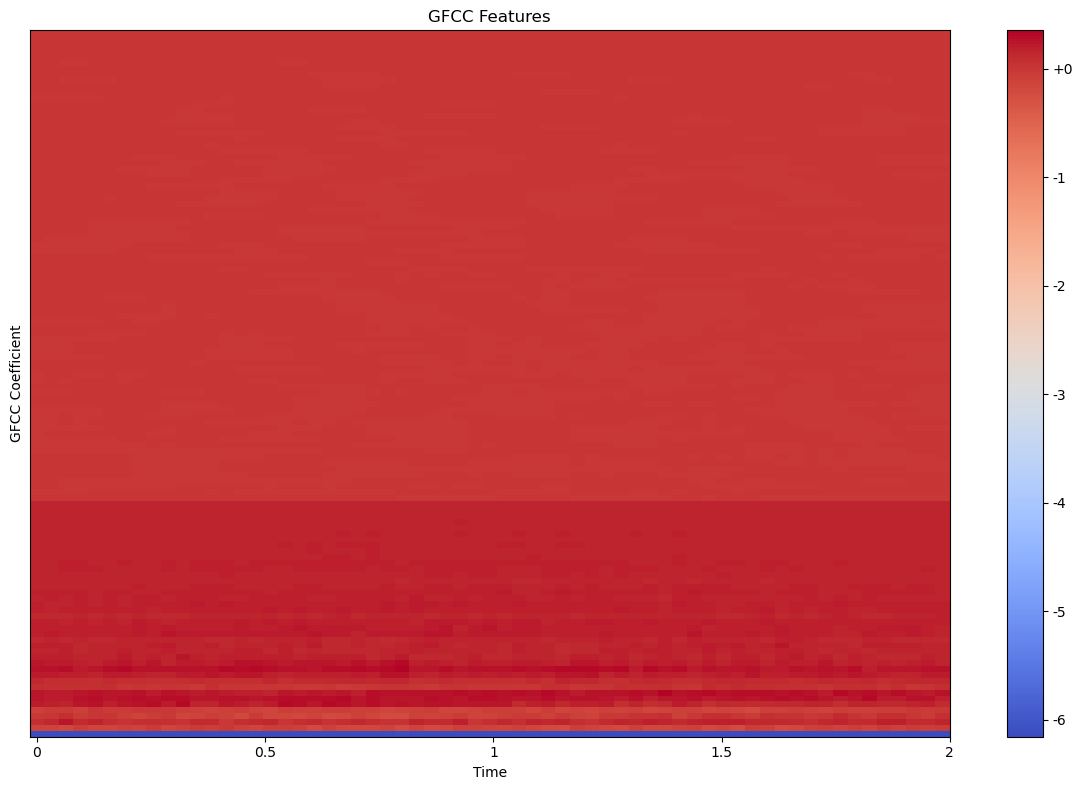

In [204]:
gfcc_features = gfcc_extractor.extract_gfcc_features(waveform, do_cmvn=True, do_deltas=True)
gfcc_features = gfcc_features.cpu().numpy()
plot_gfcc_features(gfcc_features, target_sr, hop_length, 'GFCC Features')

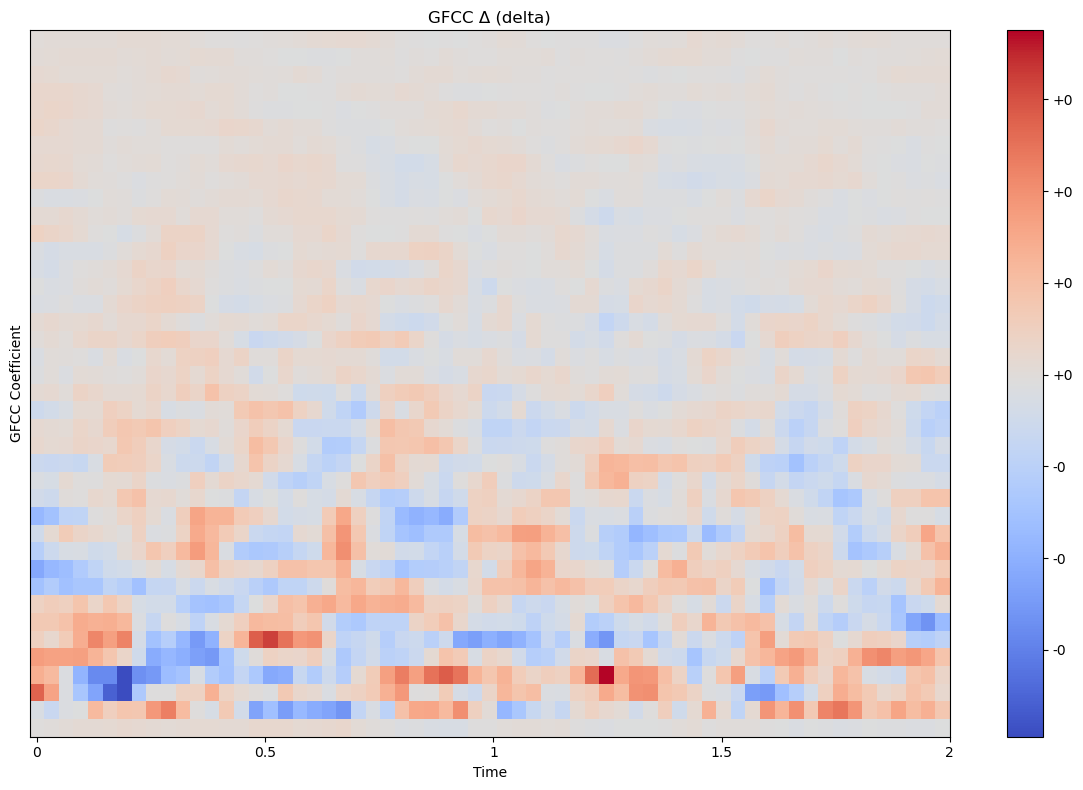

In [205]:
C = gfcc_extractor.n_gfcc
delta_1, delta_2 = gfcc_features[C:2*C], gfcc_features[2*C:3*C]
plot_gfcc_features(delta_1, target_sr, hop_length, 'GFCC Δ (delta)')

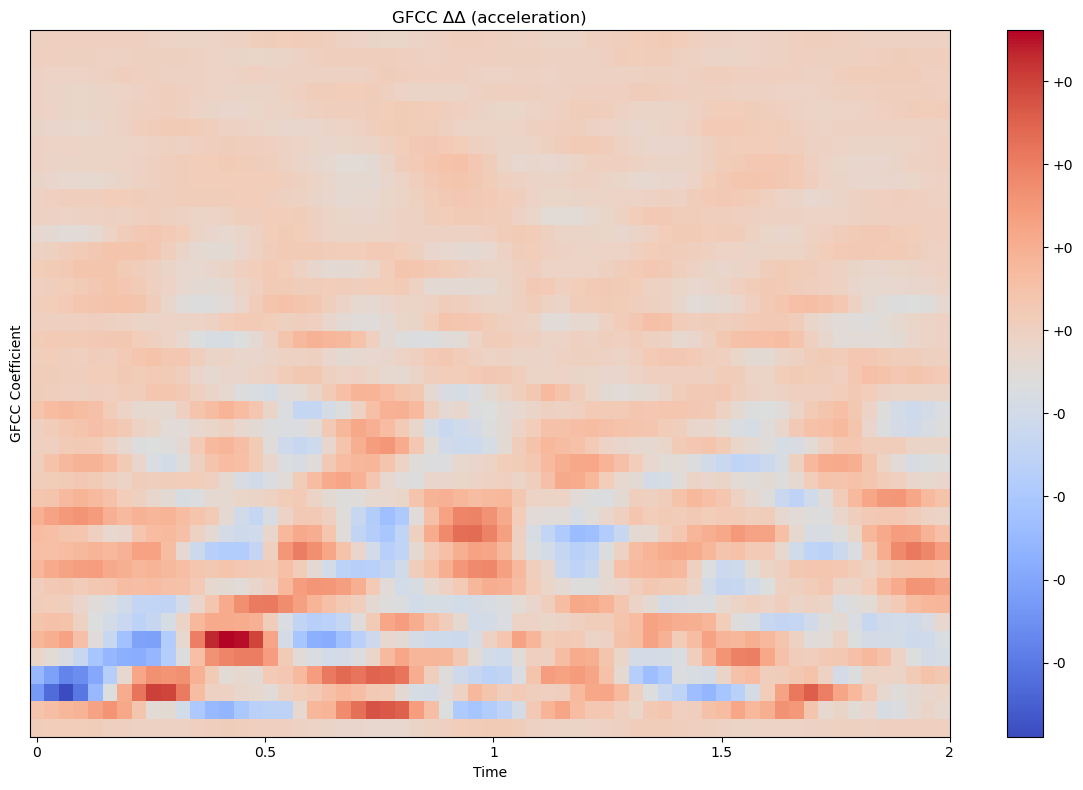

In [206]:
plot_gfcc_features(delta_2, target_sr, hop_length, 'GFCC ΔΔ (acceleration)')